<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week2.do.txt --no_mako --no_abort -->
<!-- dom:TITLE: Week 4 January 22-26, Building a Variational Monte Carlo program  -->

# Week 4 January 22-26, Building a Variational Monte Carlo program 
**Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no**, Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA

Date: **January 26**

## Overview of week 4, January 22-26
**Topics.**

* Repetition from last week and links to code templates in python and C++

* Essential ingredients: Variational Monte Carlo methods, Metropolis Algorithm, statistics and Markov Chain theory

* How to structure the VMC code

**Teaching Material, videos and written material.**

* These notes

* [Video of lecture tba](https://www.youtube.com/)

* [Handwritten note tba](https://github.com/CompPhysics/ComputationalPhysics2/blob/gh-pages/doc/HandWrittenNotes/2024/NotesJanuary26.pdf)

## Code templates for first project

1. [The C++ template](https://github.com/mortele/variational-monte-carlo-fys4411)

2. [The python template, using JAX](https://github.com/Daniel-Haas-B/FYS4411-Template)

## Basic Quantum Monte Carlo, repetition from last week

We start with the variational principle.
Given a hamiltonian $H$ and a trial wave function $\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})$, the variational principle states that the expectation value of $\cal{E}[H]$, defined through

$$
\cal {E}[H] =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})},
$$

is an upper bound to the ground state energy $E_0$ of the hamiltonian $H$, that is

$$
E_0 \le {\cal E}[H].
$$

## Multi-dimensional integrals

In general, the integrals involved in the calculation of various
expectation values are multi-dimensional ones. Traditional integration
methods such as Gauss-Legendre quadrature will not be adequate for say the
computation of the energy of a many-body system.

Here we have defined the vector $\boldsymbol{R} = [\boldsymbol{r}_1,\boldsymbol{r}_2,\dots,\boldsymbol{r}_n]$  as an array that contains the positions of all particles $n$ while the vector $\boldsymbol{\alpha} = [\alpha_1,\alpha_2,\dots,\alpha_m]$ contains the variational parameters of the model, $m$ in total.

## Trail functions

The trial wave function can be expanded in the eigenstates $\Psi_i(\boldsymbol{R})$ 
of the hamiltonian since they form a complete set, viz.,

$$
\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})=\sum_i a_i\Psi_i(\boldsymbol{R}),
$$

and assuming that the set of eigenfunctions are normalized, one obtains

$$
\frac{\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})H(\boldsymbol{R})\Psi_n(\boldsymbol{R})}
        {\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})\Psi_n(\boldsymbol{R})} =\frac{\sum_{n}a^2_n E_n}
        {\sum_{n}a^2_n} \ge E_0,
$$

where we used that $H(\boldsymbol{R})\Psi_n(\boldsymbol{R})=E_n\Psi_n(\boldsymbol{R})$.

## Variational principle
The variational principle yields the lowest energy of states with a  given symmetry.

In most cases, a wave function has only small values in large parts of 
configuration space, and a straightforward procedure which uses
homogenously distributed random points in configuration space 
will most likely lead to poor results. This may suggest that some kind
of importance sampling combined with e.g., the Metropolis algorithm 
may be  a more efficient way of obtaining the ground state energy.
The hope is then that those regions of configurations space where
the wave function assumes appreciable values are sampled more 
efficiently.

## Tedious parts of VMC calculations

The tedious part in a VMC calculation is the search for the variational
minimum. A good knowledge of the system is required in order to carry out
reasonable VMC calculations. This is not always the case, 
and often VMC calculations 
serve rather as the starting
point for so-called diffusion Monte Carlo calculations (DMC). Diffusion Monte Carlo  is a way of
solving exactly the many-body Schroedinger equation by means of 
a stochastic procedure. A good guess on the binding energy
and its wave function is however necessary. 
A carefully performed VMC calculation can aid in this context.

## Bird's eye view  on Variational MC

The basic procedure of a Variational Monte Carlo calculations consists thus of 

1. Construct first a trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$,  for a many-body system consisting of $n$ particles located at positions  $\boldsymbol{R}=(\boldsymbol{R}_1,\dots ,\boldsymbol{R}_n)$. The trial wave function depends on $\alpha$ variational parameters $\boldsymbol{\alpha}=(\alpha_1,\dots ,\alpha_M)$.

2. Then we evaluate the expectation value of the hamiltonian $H$

$$
\overline{E}[\boldsymbol{\alpha}]=\frac{\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}.
$$

1. Thereafter we vary $\boldsymbol{\alpha}$ according to some minimization algorithm and return eventually to the first step if we are not satisfied with the results.

Here we have used the notation $\overline{E}$ to label the expectation value of the energy.

## Linking with standard statistical expressions for expectation values

In order to bring in the Monte Carlo machinery, we define first a likelihood distribution, or probability density distribution (PDF). Using our ansatz for the trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$ we define a PDF

$$
P(\boldsymbol{R})= \frac{\left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2}{\int \left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2d\boldsymbol{R}}.
$$

This is our model for  probability distribution function.
The approximation to the expectation value of the Hamiltonian is now

$$
\overline{E}[\boldsymbol{\alpha}] = 
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}.
$$

## The local energy
We define a new quantity

<!-- Equation labels as ordinary links -->
<div id="eq:locale1"></div>

$$
E_L(\boldsymbol{R};\boldsymbol{\alpha})=\frac{1}{\psi_T(\boldsymbol{R};\boldsymbol{\alpha})}H\psi_T(\boldsymbol{R};\boldsymbol{\alpha}),
\label{eq:locale1} \tag{1}
$$

called the local energy, which, together with our trial PDF yields a new expression (and which look simlar to the the expressions for moments in statistics)

<!-- Equation labels as ordinary links -->
<div id="eq:vmc1"></div>

$$
\overline{E}[\boldsymbol{\alpha}]=\int P(\boldsymbol{R})E_L(\boldsymbol{R};\boldsymbol{\alpha}) d\boldsymbol{R}\approx \frac{1}{N}\sum_{i=1}^NE_L(\boldsymbol{R_i};\boldsymbol{\alpha})
\label{eq:vmc1} \tag{2}
$$

with $N$ being the number of Monte Carlo samples. The expression on the right hand side follows from Bernoulli's law of large numbers, which states that the sample mean, in the limit $N\rightarrow \infty$ approaches the true mean

## The Monte Carlo algorithm

The Algorithm for performing a variational Monte Carlo calculations runs as this

   * Initialisation: Fix the number of Monte Carlo steps. Choose an initial $\boldsymbol{R}$ and variational parameters $\alpha$ and calculate $\left|\psi_T^{\alpha}(\boldsymbol{R})\right|^2$. 

   * Initialise the energy and the variance and start the Monte Carlo calculation.

      * Calculate  a trial position  $\boldsymbol{R}_p=\boldsymbol{R}+r*step$ where $r$ is a random variable $r \in [0,1]$.

      * Metropolis algorithm to accept or reject this move  $w = P(\boldsymbol{R}_p)/P(\boldsymbol{R})$.

      * If the step is accepted, then we set $\boldsymbol{R}=\boldsymbol{R}_p$. 

      * Update averages

   * Finish and compute final averages.

Observe that the jumping in space is governed by the variable *step*. This is often referred to as the  **brute-force** sampling and is normally replaced by what is called **importance sampling**, discussed in more detail next week..

## Example from last week, the harmonic oscillator in one dimension (best seen with jupyter-notebook)

We present here a well-known example, the harmonic oscillator in
one dimension for one particle. This will also serve the aim of
introducing our next model, namely that of interacting electrons in a
harmonic oscillator trap.

Here as well, we do have analytical solutions and the energy of the
ground state, with $\hbar=1$, is $1/2\omega$, with $\omega$ being the
oscillator frequency. We use the following trial wave function

$$
\psi_T(x;\alpha) = \exp{-(\frac{1}{2}\alpha^2x^2)},
$$

which results in a local energy

$$
\frac{1}{2}\left(\alpha^2+x^2(1-\alpha^4)\right).
$$

We can compare our numerically calculated energies with the exact energy as function of $\alpha$

$$
\overline{E}[\alpha] = \frac{1}{4}\left(\alpha^2+\frac{1}{\alpha^2}\right).
$$

Similarly, with the above ansatz, we can also compute the exact variance which reads

$$
\sigma^2[\alpha]=\frac{1}{4}\left(1+(1-\alpha^4)^2\frac{3}{4\alpha^4}\right)-\overline{E}.
$$

Our code for computing the energy of the ground state of the harmonic oscillator follows here. We start by defining directories where we store various outputs.

In [1]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

We proceed with the implementation of the Monte Carlo algorithm but list first the ansatz for the wave function and the expression for the local energy

In [2]:
%matplotlib inline

# VMC for the one-dimensional harmonic oscillator
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from decimal import *
# Trial wave function for the Harmonic oscillator in one dimension
def WaveFunction(r,alpha):
    return exp(-0.5*alpha*alpha*r*r)

# Local energy  for the Harmonic oscillator in one dimension
def LocalEnergy(r,alpha):
    return 0.5*r*r*(1-alpha**4) + 0.5*alpha*alpha

Note that in the Metropolis algorithm there is no need to compute the
trial wave function, mainly since we are just taking the ratio of two
exponentials. It is then from a computational point view, more
convenient to compute the argument from the ratio and then calculate
the exponential. Here we have refrained from this purely of
pedagogical reasons.

In [3]:
# The Monte Carlo sampling with the Metropolis algo
def MonteCarloSampling():

    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = 0.0
    PositionNew = 0.0

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.4
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0
        #Initial position
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position 
            PositionNew = PositionOld + StepSize*(random() - .5)
            wfnew = WaveFunction(PositionNew,alpha)
            #Metropolis test to see whether we accept the move
            if random() <= wfnew**2 / wfold**2:
                PositionOld = PositionNew
                wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))
    return Energies, AlphaValues, Variances

Finally, the results are presented here with the exact energies and variances as well.

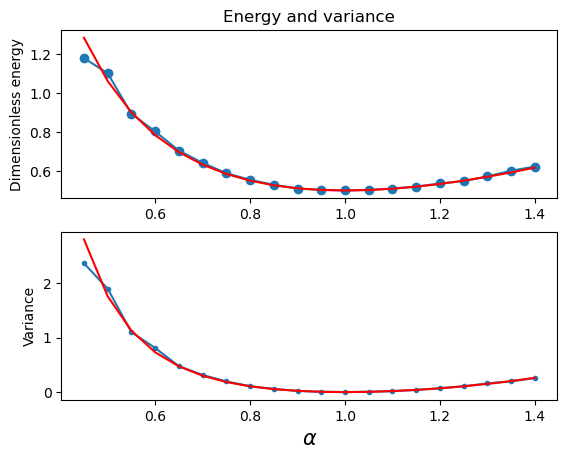

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.45  1.180614      1.285193  2.365134        2.803442
1    0.50  1.102708      1.062500  1.897733        1.757812
2    0.55  0.894354      0.902071  1.098958        1.127465
3    0.60  0.803621      0.784444  0.810480        0.730706
4    0.65  0.704845      0.697341  0.474894        0.472569
5    0.70  0.641836      0.632704  0.314429        0.300629
6    0.75  0.588947      0.585069  0.195473        0.184613
7    0.80  0.554685      0.550625  0.108195        0.106376
8    0.85  0.529034      0.526646  0.056878        0.054712
9    0.90  0.509911      0.511142  0.022084        0.022532
10   0.95  0.503576      0.502633  0.005542        0.005280
11   1.00  0.500000      0.500000  0.000000        0.000000
12   1.05  0.502961      0.502382  0.004645        0.004776
13   1.10  0.510123      0.509112  0.017847        0.018389
14   1.15  0.519669      0.519661  0.040372        0.040095
15   1.20  0.536026      0.533611  0.070

In [4]:
#Here starts the main program with variable declarations
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = 0.25*(AlphaValues*AlphaValues+1.0/(AlphaValues*AlphaValues))
ExactVariance = 0.25*(1.0+((1.0-AlphaValues**4)**2)*3.0/(4*(AlphaValues**4)))-ExactEnergies*ExactEnergies

#simple subplot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)

For $\alpha=1$ we have the exact eigenpairs, as can be deduced from the
table here. With $\omega=1$, the exact energy is $1/2$ a.u. with zero
variance, as it should. We see also that our computed variance follows rather well the exact variance.
Increasing the number of Monte Carlo cycles will improve our statistics (try to increase the number of Monte Carlo cycles).

The fact that the variance is exactly equal to zero when $\alpha=1$ is that 
we then have the exact wave function, and the action of the hamiltionan
on the wave function

$$
H\psi = \mathrm{constant}\times \psi,
$$

yields just a constant. The integral which defines various 
expectation values involving moments of the hamiltonian becomes then

$$
\langle H^n \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})H^n(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=
\mathrm{constant}\times\frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=\mathrm{constant}.
$$

**This gives an important information: the exact wave function leads to zero variance!**
As we will see below, many practitioners perform a minimization on both the energy and the variance.

## Why Markov chains, Brownian motion and the Metropolis algorithm

* We want to study a physical system which evolves towards equilibrium, from given  initial conditions.

* We start with a PDF $w(x_0,t_0)$  and we want to understand how the system evolves with time.

* We want to reach a situation where after a given number of time steps we obtain a steady state. This means that the system reaches its most likely state (equilibrium situation)

* Our PDF is normally a multidimensional object whose normalization constant is impossible to find.

* Analytical calculations from $w(x,t)$ are not possible.

* To sample directly from from $w(x,t)$ is not possible/difficult.

* The transition probability $W$ is also not  known.

* How can we establish that we have reached a steady state?   Sounds impossible!

**Use Markov chain Monte Carlo**

## Brownian motion and Markov processes
A Markov process is a random walk with a selected probability for making a
move. The new move is independent of the previous history of the system.

The Markov process is used repeatedly in Monte Carlo simulations in order to generate
new random states.

The reason for choosing a Markov process is that when it is run for a
long enough time starting with a random state, we will eventually reach the most likely state of the system.

In thermodynamics, this means that after a certain number of Markov processes
we reach an equilibrium distribution.

This mimicks the way a real system reaches
its most likely state at a given temperature of the surroundings.

## Brownian motion and Markov processes, Ergodicity and Detailed balance

To reach this distribution, the Markov process needs to obey two important conditions, that of
**ergodicity** and **detailed balance**. These conditions impose then constraints on our algorithms
for accepting or rejecting new random states.

The Metropolis algorithm discussed here
abides to both these constraints.

The Metropolis algorithm is widely used in Monte Carlo
simulations and the understanding of it rests within
the interpretation of random walks and Markov processes.

For a proof the ergodic theorem see <https://www.pnas.org/doi/10.1073/pnas.17.2.656>.

## Brownian motion and Markov processes, jargon

In a random walk one defines a mathematical entity called a **walker**, 
whose  attributes
completely define the state of the system in question. 

The state of the system  can refer to any physical quantities,
from the vibrational state of a molecule specified by a set of quantum numbers, 
to the brands of coffee in your favourite supermarket.

The walker moves in an appropriate state space by a combination of 
deterministic and random displacements from its previous
position.

This sequence of steps forms a **chain**.

## Brownian motion and Markov processes, sequence of ingredients

* We want to study a physical system which evolves towards equilibrium, from given  initial conditions.

* Markov chains are intimately linked with the physical process of diffusion. 

* From a Markov chain we can then derive the conditions for detailed balance and ergodicity. These are the conditions needed for obtaining a steady state.

* The widely used algorithm for doing this is the so-called Metropolis algorithm, in its refined form the Metropolis-Hastings algorithm.

## Applications: almost every field in science

* Financial engineering, see for example Patriarca *et al*, Physica **340**, [page 334 (2004)](http://www.sciencedirect.com/science/article/pii/S0378437104004327).

* Neuroscience, see for example Lipinski, Physics Medical Biology **35**, [page 441 (1990)](http://iopscience.iop.org/article/10.1088/0031-9155/35/3/012/meta;jsessionid=FA91B191036E1F10948F7C42B6A6D295.c1) or Farnell and Gibson, Journal of Computational Physics **208**, [page 253 (2005)](http://www.sciencedirect.com/science/article/pii/S0021999105001087)

* Tons of applications in physics

* and chemistry

* and biology, medicine

* Nobel prize in economy to Black and Scholes

$$
\frac{\partial V}{\partial t}+\frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0.
$$

The Black and Scholes equation is a partial differential equation, which describes the price
of the option over time. It is a diffusion equation with a random term.

The list of applications is endless

## Markov processes
A Markov process allows in principle for a microscopic description of Brownian motion.
As with the random walk studied in the previous section, we consider a particle 
which moves along the  $x$-axis in the form of a series of jumps with step length 
$\Delta x = l$. Time and space are discretized and the subsequent moves are
statistically independent, i.e., the new move depends only on the previous step
and not on the results from earlier trials. 
We start at a position $x=jl=j\Delta x$ and move to 
a new position $x =i\Delta x$ during a step $\Delta t=\epsilon$, where 
$i\ge  0$ and $j\ge 0$ are integers. 
The original probability distribution function (PDF) of the particles is given by  
$w_i(t=0)$ where $i$ refers to a specific position on the grid in

The function $w_i(t=0)$ is now the discretized version of $w(x,t)$.
We can regard the discretized PDF as a vector.

## Markov processes
For the Markov process we have a transition probability from a position
$x=jl$ to a position $x=il$ given by

$$
W_{ij}(\epsilon)=W(il-jl,\epsilon)=\left\{\begin{array}{cc}\frac{1}{2} & |i-j| = 1\\
             0 & \mathrm{else} \end{array} \right. ,
$$

where $W_{ij}$ is normally called 
the transition probability and we can represent it, see below,
as a matrix. 
**Here we have specialized to a case where the transition probability is known**.

Our new PDF $w_i(t=\epsilon)$ is now related to the PDF at
$t=0$ through the relation

$$
w_i(t=\epsilon) =\sum_{j} W(j\rightarrow i)w_j(t=0).
$$

This equation represents the discretized time-development of an original 
PDF with equal probability of jumping left or right.

## Markov processes, the probabilities

Since both $\boldsymbol{W}$ and $\boldsymbol{w}$ represent probabilities, they have to be normalized, i.e., we require
that at each time step we have

$$
\sum_i w_i(t) = 1,
$$

and

$$
\sum_j W(j\rightarrow i) = 1,
$$

which applies for all $j$-values.
The further constraints are
$0 \le W_{ij} \le 1$  and  $0 \le w_{j} \le 1$.
Note that the probability for remaining at the same place is in general 
not necessarily equal zero.

## Markov processes
The time development of our initial PDF can now be represented through the action of
the transition probability matrix applied $n$ times. At a 
time  $t_n=n\epsilon$ our initial distribution has developed into

$$
w_i(t_n) = \sum_jW_{ij}(t_n)w_j(0),
$$

and defining

$$
W(il-jl,n\epsilon)=(W^n(\epsilon))_{ij}
$$

we obtain

$$
w_i(n\epsilon) = \sum_j(W^n(\epsilon))_{ij}w_j(0),
$$

or in matrix form

<!-- Equation labels as ordinary links -->
<div id="eq:wfinal"></div>

$$
\begin{equation} \label{eq:wfinal} \tag{3}
   \boldsymbol{w}(n\epsilon) = \boldsymbol{W}^n(\epsilon)\boldsymbol{w}(0).
\end{equation}
$$

## An Illustrative Example

The following simple example may help in understanding the meaning of 
the transition matrix $\hat{W}$ and the vector $\hat{w}$.
Consider the $4\times 4$ matrix $\hat{W}$

$$
\boldsymbol{W} = \left(\begin{array}{cccc} 1/4 & 1/9 & 3/8 & 1/3 \\                   
                                       2/4 & 2/9 & 0 & 1/3\\                   
                                       0   & 1/9 & 3/8 & 0\\
                                       1/4 & 5/9&  2/8 & 1/3 \end{array} \right),
$$

and we choose our initial state as

$$
\boldsymbol{w}(t=0)=  \left(\begin{array}{c} 1\\                   
                                 0\\
                                 0 \\                   
                                 0 \end{array} \right).
$$

## An Illustrative Example
We note that both the vector and the matrix are properly normalized. Summing the vector elements gives one and
summing over columns for the matrix results also in one.  Furthermore, the largest eigenvalue is one.
We act then on $\boldsymbol{w}$ with $\boldsymbol{W}$.
The first iteration is

$$
\boldsymbol{w}(t=\epsilon) = \boldsymbol{W}\boldsymbol{w}(t=0),
$$

resulting in

$$
\boldsymbol{w}(t=\epsilon)=  \left(\begin{array}{c} 1/4\\                   
                                1/2 \\
                                0 \\                   
                                1/4 \end{array} \right).
$$

## An Illustrative Example, next step

The next iteration results in

$$
\boldsymbol{w}(t=2\epsilon) = \boldsymbol{W}\boldsymbol{w}(t=\epsilon),
$$

resulting in

$$
\boldsymbol{w}(t=2\epsilon)=  \left(\begin{array}{c} 0.201389\\
   0.319444 \\
   0.055556 \\
   0.423611 \end{array} \right).
$$

Note that the vector $\boldsymbol{w}$ is always normalized to $1$.

## An Illustrative Example, the steady state
We find the steady state of the system by solving the set of equations

$$
w(t=\infty) = Ww(t=\infty),
$$

which is an eigenvalue problem with eigenvalue equal to **one**!
This set of equations reads

$$
W_{11}w_1(t=\infty) +W_{12}w_2(t=\infty) +W_{13}w_3(t=\infty)+ W_{14}w_4(t=\infty)=w_1(t=\infty) \nonumber
$$

$$
W_{21}w_1(t=\infty) + W_{22}w_2(t=\infty) + W_{23}w_3(t=\infty)+ W_{24}w_4(t=\infty)=w_2(t=\infty) \nonumber
$$

$$
W_{31}w_1(t=\infty) + W_{32}w_2(t=\infty) + W_{33}w_3(t=\infty)+ W_{34}w_4(t=\infty)=w_3(t=\infty) \nonumber
$$

$$
W_{41}w_1(t=\infty) + W_{42}w_2(t=\infty) + W_{43}w_3(t=\infty)+ W_{44}w_4(t=\infty)=w_4(t=\infty) \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation} 
\label{_auto1} \tag{4}
\end{equation}
$$

with the constraint that

$$
\sum_i w_i(t=\infty) = 1,
$$

yielding as solution

$$
\boldsymbol{w}(t=\infty)=  \left(\begin{array}{c}0.244318 \\                   
                                 0.319602 \\  0.056818 \\  0.379261 \end{array} \right).
$$

## Code for the iterative process

In [7]:
from  matplotlib import pyplot as plt
import numpy as np

# Define dimension of matrix and vectors
Dim = 4
#Setting up a transition probability matrix
TransitionMatrix = np.matrix('0.25 0.1111 0.375 0.3333; 0.5 0.2222 0.0 0.3333; 0.0 0.1111 0.375 0.0; 0.25 0.5556 0.25 0.3333')
# Making a copy of the transition matrix
W = TransitionMatrix
print(W)
# our first state
wold = np.zeros(Dim)
wold[0] = 1.0
wnew = np.zeros(Dim)

# diagonalize and obtain eigenvalues, not necessarily sorted
EigValues, EigVectors = np.linalg.eig(TransitionMatrix)
# sort eigenvectors and eigenvalues
permute = EigValues.argsort()
EigValues = EigValues[permute]
EigVectors = EigVectors[:,permute]
for i in range(Dim):
    print(EigValues[i])


count = 0
while count < 50:
      for i in range(Dim):
          wnew[i] = W[i,:] @ wold
      count = count + 1
      print(count, wnew)
      wold = wnew

[[0.25   0.1111 0.375  0.3333]
 [0.5    0.2222 0.     0.3333]
 [0.     0.1111 0.375  0.    ]
 [0.25   0.5556 0.25   0.3333]]
(-0.06304544821513006-0.2123618950858686j)
(-0.06304544821513006+0.2123618950858686j)
(0.30662882408582764+0j)
(0.9999620723444322+0j)
1 [0.25 0.5  0.   0.25]
2 [0.201375  0.2951125 0.032787  0.30583  ]
3 [0.19735901 0.26618664 0.04186846 0.30963331]
4 [0.19781454 0.26125473 0.04472607 0.30898906]
5 [0.19823737 0.26015554 0.04567556 0.3085067 ]
6 [0.19841624 0.25983997 0.04599655 0.30829557]
7 [0.1984759  0.2597293  0.04610463 0.30820565]
8 [0.19848908 0.25968133 0.04613983 0.30816112]
9 [0.19848541 0.259654   0.04615    0.30813271]
10 [0.19847579 0.25963365 0.04615155 0.30810992]
11 [0.19846411 0.25961569 0.04615013 0.30808908]
12 [0.19845172 0.25959856 0.0461477  0.3080689 ]
13 [0.19843908 0.2595817  0.04614491 0.30804896]
14 [0.19842636 0.25956495 0.04614201 0.3080291 ]
15 [0.19841361 0.25954823 0.04613906 0.30800926]
16 [0.19840085 0.25953153 0.0461361  0.307

## Small exercise

Write a small code which diagonalized the matrix $\boldsymbol{W}$ and find the eigenpairs anc ompare the coefficients $w_i$.
**Note:** You may need to normalize the eigenvectors from the diagonalization procedure. What is the largest eigenvalue?

## What do the results mean?

We have after $t$-steps

$$
\boldsymbol{w}(t) = \boldsymbol{W}^t\boldsymbol{w}(0),
$$

with $\boldsymbol{w}(0)$ the distribution at $t=0$ and $\boldsymbol{W}$ representing the 
transition probability matrix.

## Understanding the basics

We can always expand $\boldsymbol{w}(0)$ in terms of the right eigenvectors 
$\boldsymbol{v}$ of $\boldsymbol{W}$ as

$$
\boldsymbol{w}(0)  = \sum_i\alpha_i\boldsymbol{v}_i,
$$

resulting in

$$
\boldsymbol{w}(t) = \boldsymbol{W}^t\boldsymbol{w}(0)=\boldsymbol{W}^t\sum_i\alpha_i\boldsymbol{v}_i=
\sum_i\lambda_i^t\alpha_i\boldsymbol{v}_i,
$$

with $\lambda_i$ the $i^{\mathrm{th}}$ eigenvalue corresponding to  
the eigenvector $\boldsymbol{v}_i$. 

If we assume that $\lambda_0$ is the largest eigenvector we see that in the limit $t\rightarrow \infty$,
$\boldsymbol{w}(t)$ becomes proportional to the corresponding eigenvector 
$\boldsymbol{v}_0$. This is our steady state or final distribution.

## Basics of the Metropolis Algorithm

The Metropolis
algorithm is a method to sample a normalized probability
distribution by a stochastic process. We define ${\cal w}_i^{(n)}$ to
be the probability for finding the system in the state $i$ at step $n$.

In the simulations, our assumption is that we have a model for ${\cal w}_i^{(n)}$, but we do not know $W$.
We will hence model $W$ in terms of a likelihood for making transition $T$ and a likelihood for accepting a transition.
That is

$$
W_{i\rightarrow j}=A_{i\rightarrow j}T_{i\rightarrow j}
$$

## The basic of the Metropolis Algorithm

* Sample a possible new state $j$ with some probability $T_{i\rightarrow j}$.

* Accept the new state $j$ with probability $A_{i \rightarrow j}$ and use it as the next sample.

* With probability $1-A_{i\rightarrow j}$ the move is rejected and the original state $i$ is used again as a sample.

We wish to derive the required properties of $T$ and $A$ such that
${\cal w}_i^{(n\rightarrow \infty)} \rightarrow p_i$ so that starting
from any distribution, the method converges to the correct distribution.
Note that the description here is for a discrete probability distribution.
Replacing probabilities $p_i$ with expressions like $p(x_i)dx_i$ will
take all of these over to the corresponding continuum expressions.

## More on the Metropolis

The dynamical equation for ${\cal w}_i^{(n)}$ can be written directly from
the description above. The probability of being in the state $i$ at step $n$
is given by the probability of being in any state $j$ at the previous step,
and making an accepted transition to $i$ added to the probability of
being in the state $i$, making a transition to any state $j$ and
rejecting the move:

<!-- Equation labels as ordinary links -->
<div id="eq:eq1"></div>

$$
\begin{equation}
\label{eq:eq1} \tag{5}
{\cal w}^{(n)}_i = \sum_j \left [
{\cal w}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
+{\cal w}^{(n-1)}_iT_{i\rightarrow j}\left ( 1- A_{i\rightarrow j} \right)
\right ] \,.
\end{equation}
$$

## Metropolis algorithm, setting it up
Since the probability of making some transition must be 1,
$\sum_j T_{i\rightarrow j} = 1$, and Eq. ([5](#eq:eq1)) becomes

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
{\cal w}^{(n)}_i = {\cal w}^{(n-1)}_i +
 \sum_j \left [
{\cal w}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
-{\cal w}^{(n-1)}_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] \,.
\label{_auto2} \tag{6}
\end{equation}
$$

## Metropolis continues

For large $n$ we require that ${\cal w}^{(n\rightarrow \infty)}_i = p_i$,
the desired probability distribution. Taking this limit, gives the
balance requirement

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\sum_j \left [p_jT_{j\rightarrow i} A_{j\rightarrow i}-p_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] = 0,
\label{_auto3} \tag{7}
\end{equation}
$$

## Detailed Balance

The balance requirement is very weak. Typically the much stronger detailed
balance requirement is enforced, that is rather than the sum being
set to zero, we set each term separately to zero and use this
to determine the acceptance probabilities. Rearranging, the result is

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\frac{ A_{j\rightarrow i}}{A_{i\rightarrow j}}
= \frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}} \,.
\label{_auto4} \tag{8}
\end{equation}
$$

This is the [detailed balance requirement](https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf)

## More on Detailed Balance

The Metropolis choice is to maximize the $A$ values, that is

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
A_{j \rightarrow i} = \min \left ( 1,
\frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}}\right ).
\label{_auto5} \tag{9}
\end{equation}
$$

Other choices are possible, but they all correspond to multilplying
$A_{i\rightarrow j}$ and $A_{j\rightarrow i}$ by the same constant
smaller than unity. The penalty function method uses just such
a factor to compensate for $p_i$ that are evaluated stochastically
and are therefore noisy.

Having chosen the acceptance probabilities, we have guaranteed that
if the  ${\cal w}_i^{(n)}$ has equilibrated, that is if it is equal to $p_i$,
it will remain equilibrated. Next we need to find the circumstances for
convergence to equilibrium.

## Dynamical Equation

The dynamical equation can be written as

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
{\cal w}^{(n)}_i = \sum_j M_{ij}{\cal w}^{(n-1)}_j
\label{_auto6} \tag{10}
\end{equation}
$$

with the matrix $M$ given by

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
M_{ij} = \delta_{ij}\left [ 1 -\sum_k T_{i\rightarrow k} A_{i \rightarrow k}
\right ] + T_{j\rightarrow i} A_{j\rightarrow i} \,.
\label{_auto7} \tag{11}
\end{equation}
$$

Summing over $i$ shows that $\sum_i M_{ij} = 1$, and since
$\sum_k T_{i\rightarrow k} = 1$, and $A_{i \rightarrow k} \leq 1$, the
elements of the matrix satisfy $M_{ij} \geq 0$. The matrix $M$ is therefore
a stochastic matrix.

## Interpreting the Metropolis Algorithm

The Metropolis method is simply the power method for computing the
right eigenvector of $\boldsymbol{M}$ with the largest magnitude eigenvalue.
By construction, the correct probability distribution is a right eigenvector
with eigenvalue 1. Therefore, for the Metropolis method to converge
to this result, we must show that $\boldsymbol{M}$ has only one eigenvalue with this
magnitude, and all other eigenvalues are smaller.

Even a defective matrix has at least one left and right eigenvector for
each eigenvalue. An example of a defective matrix is

$$
\begin{bmatrix}
0 & 1\\
0 & 0 \\
\end{bmatrix},
$$

with two zero eigenvalues, only one right eigenvector

$$
\begin{bmatrix}
1 \\
0\\
\end{bmatrix}
$$

and only one left eigenvector $(0\ 1)$.

## Gershgorin bounds and Metropolis

The Gershgorin bounds for the eigenvalues can be derived by multiplying on
the left with the eigenvector with the maximum and minimum eigenvalues,

$$
\sum_i \psi^{\rm max}_i M_{ij} = \lambda_{\rm max}  \psi^{\rm max}_j
\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation} 
\sum_i \psi^{\rm min}_i M_{ij} = \lambda_{\rm min}  \psi^{\rm min}_j
\label{_auto8} \tag{12}
\end{equation}
$$

## Normalizing the Eigenvectors

Next we choose the normalization of these eigenvectors so that the
largest element (or one of the equally largest elements)
has value 1. Let's call this element $k$, and
we can therefore bound the magnitude of the other elements to be less
than or equal to 1.
This leads to the inequalities, using the property that $M_{ij}\geq 0$,

$$
\begin{eqnarray}
\sum_i M_{ik} \leq \lambda_{\rm max}
\nonumber\\
M_{kk}-\sum_{i \neq k} M_{ik} \geq \lambda_{\rm min}
\end{eqnarray}
$$

where the equality from the maximum
will occur only if the eigenvector takes the value 1 for all values of
$i$ where $M_{ik} \neq 0$, and the equality for the minimum will
occur only if the eigenvector takes the value -1 for all values of $i\neq k$
where $M_{ik} \neq 0$.

## More Metropolis analysis

That the maximum eigenvalue is 1 follows immediately from the property
that $\sum_i M_{ik} = 1$. Similarly the minimum eigenvalue can be -1,
but only if $M_{kk} = 0$ and the magnitude of all the other elements
$\psi_i^{\rm min}$ of
the eigenvector that multiply nonzero elements $M_{ik}$ are -1.

Let's first see what the properties of $M$ must be
to eliminate any -1 eigenvalues. 
To have a -1 eigenvalue, the left eigenvector must contain only $\pm 1$
and $0$ values. Taking in turn each $\pm 1$ value as the maximum, so that
it corresponds to the index $k$, the nonzero $M_{ik}$ values must
correspond to $i$ index values of the eigenvector which have opposite
sign elements. That is, the $M$ matrix must break up into sets of
states that always make transitions from set A to set B ... back to set A.
In particular, there can be no rejections of these moves in the cycle
since the -1 eigenvalue requires $M_{kk}=0$. To guarantee no eigenvalues
with eigenvalue -1, we simply have to make sure that there are no
cycles among states. Notice that this is generally trivial since such
cycles cannot have any rejections at any stage. An example of such
a cycle is sampling a noninteracting Ising spin. If the transition is
taken to flip the spin, and the energy difference is zero, the Boltzmann
factor will not change and the move will always be accepted. The system
will simply flip from up to down to up to down ad infinitum. Including
a rejection probability or using a heat bath algorithm
immediately fixes the problem.

## Final Considerations I

Next we need to make sure that there is only one left eigenvector
with eigenvalue 1. To get an eigenvalue 1, the left eigenvector must be 
constructed from only ones and zeroes. It is straightforward to
see that a vector made up of
ones and zeroes can only be an eigenvector with eigenvalue 1 if the 
matrix element $M_{ij} = 0$ for all cases where $\psi_i \neq \psi_j$.
That is we can choose an index $i$ and take $\psi_i = 1$.
We require all elements $\psi_j$ where $M_{ij} \neq 0$ to also have
the value $1$. Continuing we then require all elements $\psi_\ell$ $M_{j\ell}$
to have value $1$. Only if the matrix $M$ can be put into block diagonal
form can there be more than one choice for the left eigenvector with
eigenvalue 1. We therefore require that the transition matrix not
be in block diagonal form. This simply means that we must choose
the transition probability so that we can get from any allowed state
to any other in a series of transitions.

## Final Considerations II

Finally, we note that for a defective matrix, with more eigenvalues
than independent eigenvectors for eigenvalue 1,
the left and right
eigenvectors of eigenvalue 1 would be orthogonal.
Here the left eigenvector is all 1
except for states that can never be reached, and the right eigenvector
is $p_i > 0$ except for states that give zero probability. We already
require that we can reach
all states that contribute to $p_i$. Therefore the left and right
eigenvectors with eigenvalue 1 do not correspond to a defective sector
of the matrix and they are unique. The Metropolis algorithm therefore
converges exponentially to the desired distribution.

## Final Considerations III

The requirements for the transition $T_{i \rightarrow j}$ are
* A series of transitions must let us to get from any allowed state to any other by a finite series of transitions.

* The transitions cannot be grouped into sets of states, A, B, C ,... such that transitions from $A$ go to $B$, $B$ to $C$ etc and finally back to $A$. With condition (a) satisfied, this condition will always be satisfied if either $T_{i \rightarrow i} \neq 0$ or there are some rejected moves.

## The system: two particles (fermions normally) in a harmonic oscillator trap in two dimensions

The Hamiltonian of the quantum dot is given by

$$
\hat{H} = \hat{H}_0 + \hat{V},
$$

where $\hat{H}_0$ is the many-body HO Hamiltonian, and $\hat{V}$ is the
inter-electron Coulomb interactions. In dimensionless units,

$$
\hat{V}= \sum_{i < j}^N \frac{1}{r_{ij}},
$$

with $r_{ij}=\sqrt{\mathbf{r}_i^2 - \mathbf{r}_j^2}$.

## Separating the degrees of freedom

This leads to the  separable Hamiltonian, with the relative motion part given by ($r_{ij}=r$)

$$
\hat{H}_r=-\nabla^2_r + \frac{1}{4}\omega^2r^2+ \frac{1}{r},
$$

plus a standard Harmonic Oscillator problem  for the center-of-mass motion.
This system has analytical solutions in two and three dimensions ([M. Taut 1993 and 1994](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.48.3561)).

## Variational Monte Carlo code (best seen with jupyter-notebook)
We want to perform  a Variational Monte Carlo calculation of the ground state of two electrons in a quantum dot well with different oscillator energies, assuming total spin $S=0$.
Our trial wave function has the following form

<!-- Equation labels as ordinary links -->
<div id="eq:trial"></div>

$$
\begin{equation}
   \psi_{T}(\boldsymbol{r}_1,\boldsymbol{r}_2) = 
   C\exp{\left(-\alpha_1\omega(r_1^2+r_2^2)/2\right)}
   \exp{\left(\frac{r_{12}}{(1+\alpha_2 r_{12})}\right)}, 
\label{eq:trial} \tag{13}
\end{equation}
$$

where the $\alpha$s represent our variational parameters, two in this case.

Why does the trial function look like this? How did we get there?
**This will be one of our main motivations** for switching to Machine Learning later.

To find an ansatz for the correlated part of the wave function, it is
useful to rewrite the two-particle local energy in terms of the
relative and center-of-mass motion.  
Let us denote the relative distance
between the two electrons as $r_{12}$. We omit the center-of-mass
motion since we are only interested in the case when $r_{12}
\rightarrow 0$. The contribution from the center-of-mass (CoM)
variable $\boldsymbol{R}_{\mathrm{CoM}}$ gives only a finite contribution.  We
focus only on the terms that are relevant for $r_{12}$ and for three
dimensions. 

The relevant local energy becomes then

$$
\lim_{r_{12} \rightarrow 0}E_L(R)= \frac{1}{{\cal R}_T(r_{12})}\left(2\frac{d^2}{dr_{ij}^2}+\frac{4}{r_{ij}}\frac{d}{dr_{ij}}+\frac{2}{r_{ij}}-\frac{l(l+1)}{r_{ij}^2}+2E \right){\cal R}_T(r_{12})
= 0.
$$

Set $l=0$ and we have the so-called **cusp** condition

$$
\frac{d {\cal R}_T(r_{12})}{dr_{12}} = -\frac{1}{2(l+1)} {\cal R}_T(r_{12})\qquad r_{12}\to 0
$$

The above  results in

$$
{\cal R}_T  \propto \exp{(r_{ij}/2)},
$$

for anti-parallel spins and

$$
{\cal R}_T  \propto \exp{(r_{ij}/4)},
$$

for anti-parallel spins. 
This is the so-called cusp condition for the relative motion, resulting in a minimal requirement
for the correlation part of the wave fuction.
For general systems containing more than say two electrons, we have this
condition for each electron pair $ij$.

## First code attempt for the two-electron case

First, as with the hydrogen case, we declare where to store files.

In [14]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCQdotMetropolis"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCQdotMetropolis.dat"),'w')

Thereafter we set up the analytical expressions for the wave functions and the local energy

In [15]:
# 2-electron VMC for quantum dot system in two dimensions
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

The Monte Carlo sampling without importance sampling is set up here.

In [16]:
# The Monte Carlo sampling with the Metropolis algo
def MonteCarloSampling():

    NumberMCcycles= 1000000
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = StepSize * (random() - .5)
            wfold = WaveFunction(PositionOld,alpha,beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j] + StepSize * (random() - .5)
                    wfnew = WaveFunction(PositionNew,alpha,beta)

                    #Metropolis test to see whether we accept the move
                    if random() < wfnew**2 / wfold**2:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            #We calculate mean, variance and error ...
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            Variances[ia,jb] = variance    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, Variances, AlphaValues, BetaValues

And finally comes the main part with the plots as well.

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_78935/1086845008.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


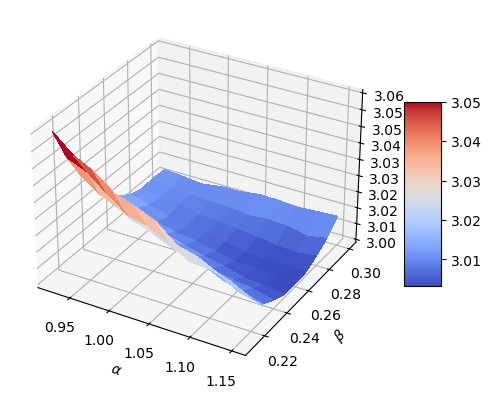

In [17]:
#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
Variances = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, Variances, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()

# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotMetropolis")
plt.show()